In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import f_regression
import time
from math import pi, cos

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load the data from Stanford Open Policing Datasets
uil="https://stacks.stanford.edu/file/druid:py883nd2578/MT-clean.csv.gz"
Mdata = pd.read_csv(uil, compression='gzip', header=0, parse_dates=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Check the datasets
Mdata.columns
Mdata.info()
Mdata.head()
Mdata.shape
# Can also use value_counts() to examine the uniqe value and its counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825118 entries, 0 to 825117
Data columns (total 33 columns):
id                       825118 non-null object
state                    825118 non-null object
stop_date                825107 non-null object
stop_time                825107 non-null object
location_raw             825114 non-null object
county_name              821062 non-null object
county_fips              821062 non-null float64
fine_grained_location    821377 non-null object
police_department        0 non-null float64
driver_gender            824999 non-null object
driver_age_raw           825118 non-null float64
driver_age               821638 non-null float64
driver_race_raw          825012 non-null object
driver_race              822379 non-null object
violation_raw            825045 non-null object
violation                825045 non-null object
search_conducted         825118 non-null bool
search_type_raw          3026 non-null object
search_type              3026 

(825118, 33)

In [4]:
# Change data type, first change the stop_date column into a datatime
Mdata["stop_date"] = pd.to_datetime(Mdata["stop_date"])
Mdata.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,lon,ethnicity,city,out_of_state,vehicle_year,vehicle_make,vehicle_model,vehicle_style,search_reason,stop_outcome_raw
0,MT-2009-00001,MT,2009-01-01,02:10,CASCADE,Cascade County,30013.0,US 89 N MM10 (SB),NaN,F,...,-111.802932,N,NaN,False,1994,FORD,EXPLORER,SPORT UTILITY,NaN,"TRAFFIC CITATION,WARNING"
1,MT-2009-00002,MT,2009-01-02,11:34,MISSOULA,Missoula County,30063.0,HWY 93 SO AND ANNS LANE S/B,NaN,M,...,-114.081142,N,NaN,False,1996,GMC,TK,TRUCK,NaN,"INFFRACTION ARREST,WARNING"
2,MT-2009-00003,MT,2009-01-03,11:36,MISSOULA,Missoula County,30063.0,P007 HWY 93 MM 77 N/B,NaN,M,...,-114.073505,N,NaN,False,1999,GMC,YUKON,SPORT UTILITY,NaN,INFFRACTION ARREST
3,MT-2009-00004,MT,2009-01-04,10:33,MISSOULA,Missoula County,30063.0,P007 HWY 93 MM 81 S/B,NaN,F,...,-114.079027,NaN,NaN,False,2002,HOND,CR-V,SPORT UTILITY,NaN,INFFRACTION ARREST
4,MT-2009-00005,MT,2009-01-04,10:46,MISSOULA,Missoula County,30063.0,P007 HWY 93 MM 81 N/B,NaN,M,...,-114.079150,NaN,NaN,False,1992,TOYT,TERCEL,SEDAN,NaN,INFFRACTION ARREST


In [ ]:
'''
Q1 What proportion of traffic stops in Montana involved male drivers? In other words, divide the number of traffic stops 
involving male drivers by the total number of stops.

0.6750723334210103

'''

In [83]:
# First check all the unique ID of stop in Montana and whetehr there is NaN in ID
Mdata["id"].nunique()
Mdata["id"].isnull().sum()


# We also need to check whether there is any NaN in the driver_gender column
Mdata["driver_gender"].isnull().sum()

# Sincere there are 119 NaN in the driver_gender column, we don't include them in the proportion calculation
proportion = Mdata.groupby("driver_gender")["id"].count()["M"]/Mdata.driver_gender.count()
print(proportion)

0.6750723334210103


In [ ]:
'''
How many more times likely are you to be arrested in Montana during a traffic stop if you have out of state plates?

1.2095129351452942
'''

In [136]:
# First check whether there is NaN, and find there are 4699 NaNs in the out_of_state column, but no NaN for is_arrested column
Mdata["out_of_state"].isnull().sum()
Mdata["is_arrested"].isnull().sum()

# If we disgard the NaNs
times = data.groupby(["out_of_state","is_arrested"])["id"].count()
print ((times[1,1]/(times[1,1]+times[1,0]))/(times[0,1]/(times[0,1]+times[0,0])))

# If we keep the NaNs and consider them as in state for a conservative calculation
times = pd.crosstab(Mdata.is_arrested == True, Mdata.out_of_state == True)
print ((times.iloc[1, 1]/(times.iloc[1, 1]+times.iloc[0, 1]))/(times.iloc[1, 0]/(times.iloc[1, 0]+times.iloc[0, 0])))

1.2095129351452942
1.2051830449542686


In [ ]:
'''
Perform a (χ2) test to determine whether the proportions of arrests in these two populations are equal. 
What is the value of the test statistic?

chi-squared statistic 

Null: there is no relationship between two variables, being arrested and being outside plate are independent.
Given the low p-value, the test result does find a significant relationship between the variables.

'''

In [162]:
# First conduct Chi-Squared Goodness-Of-Fit Test
Instate = Mdata[Mdata["out_of_state"]==False][["is_arrested"]]
Outstate = Mdata[Mdata["out_of_state"]==True][["is_arrested"]]
#Instate.is_arrested = Instate.is_arrested.apply(lambda x: 1 if x==True else 0)
#Outstate.is_arrested = Outstate.is_arrested.apply(lambda x: 1 if x==True else 0)

In [178]:
Instate_table = pd.crosstab(index=Instate["is_arrested"], columns="count")
Outstate_table = pd.crosstab(index=Outstate["is_arrested"], columns="count")

In [189]:
observed = Outstate_table
ratios = Instate_table/len(Instate)
expected = ratios * len(Outstate)
chi_squared_stat = (((observed-expected)**2)/expected).sum()
print (chi_squared_stat)

col_0
count    180.231661
dtype: float64


In [188]:
#  we compare the chi-square test statistic to a critical value based on the chi-square distribution at 98% confidence interval.
crit = stats.chi2.ppf(q = 0.95, df = 1) 
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=4)
print (crit, p_value)

3.8414588206941236 [0.]


In [190]:
stats.chisquare(f_obs= observed, f_exp= expected)

Power_divergenceResult(statistic=array([180.2316613]), pvalue=array([4.31359566e-41]))

In [210]:
# An alternative is to test the Chi-Squared Test of Independence
Independence_tab = pd.crosstab(Mdata.is_arrested, Mdata.out_of_state, margins = True)
observed = Independence_tab.iloc[0:2,0:2]
observed

out_of_state,False,True
is_arrested,,
False,604588,198773
True,12190,4868


In [216]:
expected =  np.outer(Independence_tab["All"][0:2], Independence_tab.loc["All"][0:2]) / 820419
expected = pd.DataFrame(expected)
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
chi_squared_stat

128.93246771507611

In [215]:
crit = stats.chi2.ppf(q = 0.95, df = 1)
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,df=1)
print (crit, p_value)

3.8414588206941236 0.0


In [214]:
stats.chi2_contingency(observed= observed)

(128.72916324226682,
 7.773353035854224e-30,
 1,
 array([[603954.06598092, 199406.93401908],
        [ 12823.93401908,   4234.06598092]]))

In [ ]:
'''
What proportion of traffic stops in Montana resulted in speeding violations? In other words, find the number of violations 
that include "Speeding" in the violation description and divide that number by the total number of stops 
(or rows in the Montana dataset).

0.6580998111785223

'''

In [229]:
Mdata.violation.str.contains("Speeding|speeding").sum()/Mdata.shape[0]

0.6580998111785223

In [ ]:
'''
How much more likely does a traffic stop in Montana result in a DUI than a traffic stop in Vermont? 
To compute the proportion of traffic stops that result in a DUI, divide the number of stops with "DUI" in the 
violation description by the total number of stops.

4.085999694420856
'''

In [235]:
MDUI = Mdata.violation.str.contains("DUI").sum()/Mdata.shape[0]

In [45]:
uil="https://stacks.stanford.edu/file/druid:py883nd2578/VT-clean.csv.gz"
Vdata = pd.read_csv(uil, compression='gzip', header=0)

C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [233]:
VDUI = Vdata.violation.str.contains("DUI").sum()/Vdata.shape[0]

In [237]:
ratio = MDUI/VDUI
ratio

4.085999694420856

In [ ]:
'''
What is the extrapolated, average manufacture year of vehicles involved in traffic stops in Montana in 2020? 
To answer this question, calculate the average vehicle manufacture year for each year's traffic stops. 
Extrapolate using a linear regression.

2008.84316596

'''

In [269]:
myv = Mdata.loc[:]
myv["year"]=myv["stop_date"].dt.year
myv["vehicle_year"] = pd.to_numeric(myv["vehicle_year"], errors="coerce")
myv.set_index("stop_date", inplace=True)
myv_y = myv[["vehicle_year", "year"]].resample("A").mean()
myv_y = myv_y.reset_index()
del myv_y["stop_date"]

,vehicle_year,year
0,2000.980215,2009.0
1,2001.521377,2010.0
2,2002.280938,2011.0
3,2003.362207,2012.0
4,2003.905175,2013.0
5,2004.482506,2014.0
6,2005.295767,2015.0
7,2005.872128,2016.0


In [279]:
# Apply linear regression 
lr = LinearRegression()
X, y = myv_y["year"].values[:,np.newaxis], myv_y["vehicle_year"].values
lr.fit(X,y)
print("Slope: %f" % lr.coef_[0], "Intercept: %f" % lr.intercept_)

Slope: 0.717417 Intercept: 559.661028


In [280]:
def lrplot(X,y, model):
    plt.scatter(X,y, c="red")
    plt.plot(X, model.predict(X), color="blue")
    return None

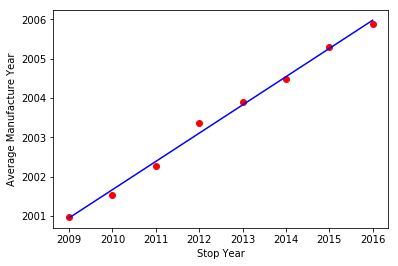

In [282]:
lrplot(X, y, lr)
plt.xlabel("Stop Year")
plt.ylabel("Average Manufacture Year")
plt.show()

In [284]:
estimate = lr.predict([[2020]])
estimate

array([2008.84316596])

In [ ]:
'''What is the p-value of this linear regression?

0.0
'''

In [304]:
Xnew = sm.add_constant(X)
params = sm.OLS(y, Xnew).fit()
print(params.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1058.
Date:                Thu, 26 Apr 2018   Prob (F-statistic):           5.61e-08
Time:                        14:52:13   Log-Likelihood:                 5.3634
No. Observations:                   8   AIC:                            -6.727
Df Residuals:                       6   BIC:                            -6.568
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        559.6610     44.379     12.611      0.0

C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


In [1]:
# p value of the linear regression. It is significant that there exists relationships between manufacture year and year of stop.
f_regression(X, y)

NameError: name 'f_regression' is not defined

In [ ]:
'''
Combining both the Vermont and Montana datasets, find the hours when the most and least number of traffic stops occurred. 
What is the difference in the total number of stops that occurred in these two hours? Hours range from 00 to 23. 
Round stop times down to compute this difference.

878

'''

In [43]:
Mdata_least = Mdata[["id", "stop_time"]]
Mdata_least["state"] = "Montana"
Mdata_least["hour"] = Mdata_least["stop_time"].str.split(":").str.get(0)

C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
Vdata_least = Vdata[["id", "stop_time"]]
Vdata_least["state"] = "Vermont"
Vdata_least["hour"] = Vdata_least["stop_time"].str.split(":").str.get(0)

C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
hourly = pd.concat([Mdata_least, Vdata_least], axis=0).groupby("hour")["id"].count()
hourly

hour
00    25490
01    16856
02     8399
03     1425
04      547
05     1710
06     8561
07    41550
08    62488
09    62233
10    61946
11    51008
12    44024
13    59281
14    82129
15    95891
16    86886
17    81437
18    82430
19    57980
20    47244
21    45891
22    44387
23    38599
Name: id, dtype: int64

In [64]:
two_state_rank = pd.DataFrame({'hour':hourly.index, 'count':hourly.values})
two_state_rank.sort_values("count", ascending=True, inplace=True)
diff = two_state_rank.iloc[1,0]-two_state_rank.iloc[0,0]
print(diff)

878


In [81]:
'''
We can use the traffic stop locations to estimate the areas of the counties in Montana. 
Represent each county as an ellipse with semi-axes given by a single standard deviation of the longitude and 
latitude of stops within that county. What is the area, in square kilometers, of the largest county measured 
in this manner? Please ignore unrealistic latitude and longitude coordinates.

'''

'\nWe can use the traffic stop locations to estimate the areas of the counties in Montana. \nRepresent each county as an ellipse with semi-axes given by a single standard deviation of the longitude and \nlatitude of stops within that county. What is the area, in square kilometers, of the largest county measured \nin this manner? Please ignore unrealistic latitude and longitude coordinates.\n\n'

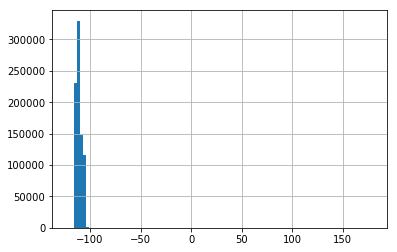

In [30]:
Mdata["lon"].hist(bins=100)
plt.show()

In [78]:
# The area of ellipse is pi*A*B where A is the semi-major axis and B is the semi-minor axis
'''Based on Wikipedia, each degree of latitude is approximately 111 kilometers away, 
each degree of Longitude is approximately 111*cos(lati) kilometers away'''
Mdata_clean = Mdata[(Mdata["lat"] > 40) & (Mdata["lat"] < 55) & (Mdata["lon"] > -120) & (Mdata["lon"] < -100)]
Mdata_area = Mdata_clean.groupby("county_name")[["lat","lon"]].std()
Mdata_area.tail()

,lat,lon
county_name,,
Treasure County,0.045461,0.138295
Valley County,0.131271,0.345317
Wheatland County,0.104154,0.131184
Wibaux County,0.069986,0.081696
Yellowstone County,0.089652,0.185244


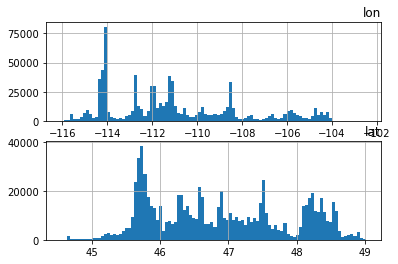

In [59]:
plt.subplot(2,1,1)
Mdata_clean["lon"].hist(bins=100)
plt.title("lon", loc="right")
plt.subplot(2,1,2)
Mdata_clean["lat"].hist(bins=100)
plt.title("lat", loc="right")
plt.show()

In [82]:
Mdata_area["area"] = Mdata_area["lat"] * Mdata_area["lon"] * 111.0 * 111.0 
Mdata_area["area"] = Mdata_area["area"].multiply(Mdata_area["lat"].apply(cos))

In [84]:
Mdata_area.sort_values("area", ascending=False, inplace=True)
Mdata_area["area"][0]

1016.112071239203